# Handwriting Recognition using Tensorflow

* Reference: https://www.kaggle.com/landlord/handwriting-recognition

## Overview
* This dataset consists of more than four hundred thousand handwritten names collected through charity projects.

* Character Recognition utilizes image processing technologies to convert characters on scanned documents into digital forms. It typically performs well in machine-printed fonts. However, it still poses difficult challenges for machines to recognize handwritten characters, because of the huge variation in individual writing styles.

* There are 206,799 first names and 207,024 surnames in total. The data was divided into a training set (331,059), testing set (41,382), and validation set (41,382) respectively.


## Cleaning:
* Data exploration of images
    * Filter out unrecognized/unreadable images
    
### Data Augmentation:
* Rotation by angle.

### Neural Network:
* Add three Convolution Layers with ReLu activation function for **feature extraction**.
* Add three Pooling Layers consecutively after convolutionalizing the images.
* Add a reshaping layer before going into RNN.
* Add a dense layer to classify 1024 inputs from previous layer into 64 outputs.
* Add two bidirectional RNN LSTM layer, required for **sequential** images.
* Add a dense layer to finalize number of character per string.

### Loss Function:
* CTC Loss: (https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).
* ADAM Optimizer which includes the advantages of the following:
    * Adaptive Gradient Algorithm (AdaGrad) - Adaptive Stochastic Gradient Descent (SGD)
    * Root Mean Square Propagation (RMSProp) 
)

# 1. Importing Libraries and Setting up Directories

In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

import cv2
import random
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import getcwd

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
print("Tensorflow Version:", tf.__version__)

for device in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  1
GPU is available
Tensorflow Version: 2.4.1


In [2]:
main_dir = r'C:\Users\user\Documents\tensorflow\kaggle_handwriting_recognition'
# Change directory to the pre-defined address.
os.chdir(main_dir)
train = pd.read_csv(main_dir + '\input\written_name_train_v2.csv')
test  = pd.read_csv(main_dir + '\input\written_name_validation_v2.csv')
path_train = f"{getcwd()}\\input\\train_v2\\train\\"
path_test  = f"{getcwd()}\\input\\validation_v2\\validation\\"

# 2. Data Exploration and Cleaning

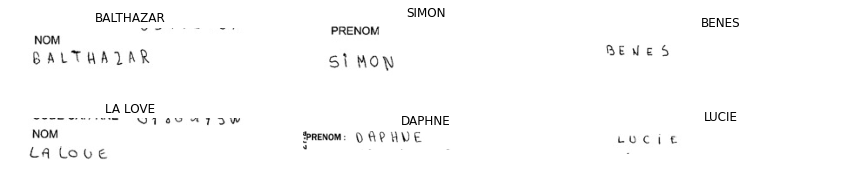

In [3]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir =  r'C:\Users\user\Documents\tensorflow\kaggle_handwriting_recognition\input\train_v2\train\\'+ train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## 2.1 Removing NA 

In [4]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in test set : ", test['IDENTITY'].isnull().sum())

train.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True)

Number of NaNs in train set      :  565
Number of NaNs in test set :  78


## 2.2 Exploration and Removal of Unreadable Image, Cleaning

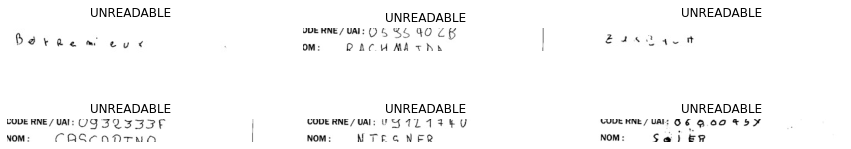

In [5]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = r'C:\Users\user\Documents\tensorflow\kaggle_handwriting_recognition\input\train_v2\train\\'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [6]:
train = train[train['IDENTITY'] != 'UNREADABLE']
test = test[test['IDENTITY'] != 'UNREADABLE']

train['IDENTITY'] = train['IDENTITY'].str.upper()
test['IDENTITY'] = test['IDENTITY'].str.upper()

train.reset_index(inplace = True, drop=True) 
test.reset_index(inplace = True, drop=True)

In [7]:
train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


## 3. Defining Helper Function

In [8]:
path_train = f"{getcwd()}\\input\\train_v2\\train\\"
path_valid = f"{getcwd()}\\input\\validation_v2\\validation\\"
file_written_train =  f"{getcwd()}\\input\\written_name_train_v2.csv"
file_written_test  =  f"{getcwd()}\\input\\written_name_validation_v2.csv"

In [9]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 30 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels

# Preprocess and crop image
def preprocess(img):
    (h, w) = img.shape
    final_img = np.ones([64, 256])*255 # blank white image
    # crop
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

# Convert label string to numerical value.
def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

# Convert numerical value back to label string.
def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

def isNaN(string):
    return string != string

# To have training_images, training_labels, testing_images, testing_labels
# To normalize the pixel values by dividing 255.
def get_data(file_written, path, size):
    with open(file_written) as file:
        images = []
        labels = []
        labels_len = []
        #skip first row.
        file.readline()
        lit = iter(enumerate(file))
        for count, row in lit:
           # if count % 1000 == 0:
               # print("%d" % (count))
            row = row.split(",")
            image_string = row[0]
            label_string = row[1].upper().replace('\n', '')
            if label_string == 'UNREADABLE' or label_string == '':
                continue
            else:
                img_dir = path + image_string
                # Declare image and normalize.
                image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
                image = preprocess(image)
                image = np.array(image/255.)
                
                # Initialize arrays to have:
                # 
                label = np.ones([1, max_str_len]) * -1
                label_len = np.zeros([1, 1])
                images_len = np.ones([size, 1]) * (num_of_timestamps-2)
                ctc_output = np.zeros([size])
                
                label[0, 0:len(label_string)] = label_to_num(label_string) 
                label_len[0] = len(label_string)
            
            labels.append(label)
            images.append(image)
            labels_len.append(label_len)
            
            if len(labels) == size:
                break
        
        images = np.array(images).astype(float)
        labels = np.array(labels).astype(float).reshape(-1, max_str_len)
        labels_len = np.array(labels_len).astype(float).reshape(-1, 1)
        
    return images, labels, labels_len, images_len, ctc_output

# 4. Set up traning and testing data

In [10]:
train_size = 20000
test_size = 2000

training_images, training_labels, training_labels_len, training_images_len, training_output = get_data(file_written_train, path_train, train_size)
testing_images, testing_labels, testing_labels_len, testing_images_len, testing_output = get_data(file_written_test, path_test, test_size)

training_labels = training_labels.reshape(-1, max_str_len)
testing_labels = testing_labels.reshape(-1, max_str_len)

In [11]:
# Keep these
print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

(20000, 256, 64)
(20000, 30)
(2000, 256, 64)
(2000, 30)


In [12]:
# Adding another dimension to the data

training_images = np.expand_dims(training_images, axis=3)
testing_images = np.expand_dims(testing_images, axis=3)

In [13]:
print('True label : ',pd.read_csv(file_written_train).loc[100, 'IDENTITY'] , '\ntrain_label_len : ',training_labels[100],'\ntraining_labels_len : ',training_labels_len[100], 
      '\ntraining_images_len : ', training_images_len[100])

True label :  NOUR 
train_label_len :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.] 
training_labels_len :  [4.] 
training_images_len :  [62.]


In [14]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)

# the ctc loss function
def ctc_lambda_func(args):
    # Args:  y_true, y_pred, input_length, label_length
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))
model_final.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 64, 32)  320         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 64, 32)  128         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 64, 32)  0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [15]:
print(training_images.shape)
print(training_labels.shape)
print(training_images_len.shape)
print(training_labels_len.shape)
print(training_output.shape)

(20000, 256, 64, 1)
(20000, 30)
(20000, 1)
(20000, 1)
(20000,)


In [16]:
print(testing_images.shape)
print(testing_labels.shape)
print(testing_images_len.shape)
print(testing_labels_len.shape)
print(testing_output.shape)

(2000, 256, 64, 1)
(2000, 30)
(2000, 1)
(2000, 1)
(2000,)


In [17]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
# with tf.device('/gpu:0'):
#     model_final.run_eagerly = True
#     history = model_final.fit(x=[training_images, training_labels, training_images_len, training_labels_len], y=training_output, 
#                     validation_data=([testing_images, testing_labels, testing_images_len, testing_labels_len], testing_output),
#                     epochs=10, batch_size = 128)
model_final.run_eagerly = True
history = model_final.fit(x=[training_images, training_labels, training_images_len, training_labels_len], y=training_output, 
                    validation_data=([testing_images, testing_labels, testing_images_len, testing_labels_len], testing_output),
                    epochs=30, batch_size = 128)

Epoch 1/30
157/157 [==============================] - 38s 215ms/step - loss: 44.3933 - val_loss: 27.7058
Epoch 2/30
157/157 [==============================] - 32s 206ms/step - loss: 20.3937 - val_loss: 20.4246
Epoch 3/30
157/157 [==============================] - 33s 208ms/step - loss: 20.0994 - val_loss: 20.2116
Epoch 4/30
157/157 [==============================] - 33s 207ms/step - loss: 19.8572 - val_loss: 19.9241
Epoch 5/30
157/157 [==============================] - 32s 207ms/step - loss: 19.6428 - val_loss: 19.5183
Epoch 6/30
157/157 [==============================] - 32s 205ms/step - loss: 19.2594 - val_loss: 18.8832
Epoch 7/30
157/157 [==============================] - 32s 207ms/step - loss: 18.5622 - val_loss: 17.9244
Epoch 8/30
157/157 [==============================] - 33s 208ms/step - loss: 17.5842 - val_loss: 16.6823
Epoch 9/30
157/157 [==============================] - 32s 206ms/step - loss: 16.2477 - val_loss: 15.3627
Epoch 10/30
157/157 [==============================] - 

# Visualization of Training/Validation loss over Time

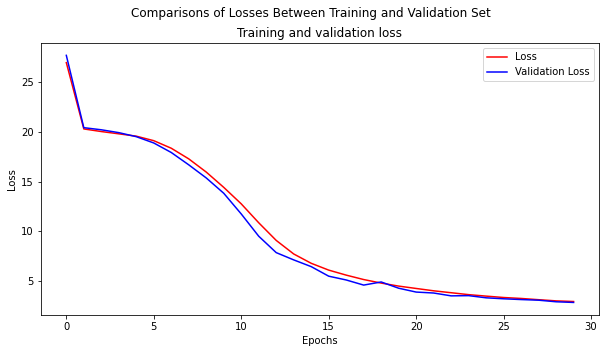

In [18]:
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(loss)) # Get number of epochs
fig,(ax1)=plt.subplots(1,1,figsize=(10,5))

ax1.plot(epochs, loss, 'r')
ax1.plot(epochs, val_loss, 'b')
ax1.set_title('Training and validation loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend(["Loss", "Validation Loss"])

fig.suptitle('Comparisons of Losses Between Training and Validation Set')
plt.show()

In [19]:
preds = model.predict(testing_images)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(test_size):
    prediction.append(num_to_label(decoded[i]))
    
true_label = []
for i in testing_labels:
    true_label.append(num_to_label(i.astype(int).tolist()))

In [20]:
correct_char = 0
total_char = 0
correct = 0

for i in range(test_size):
    pr = prediction[i]
    tr = str(true_label[i])
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/test_size))

Correct characters predicted : 78.10%
Correct words predicted      : 58.30%


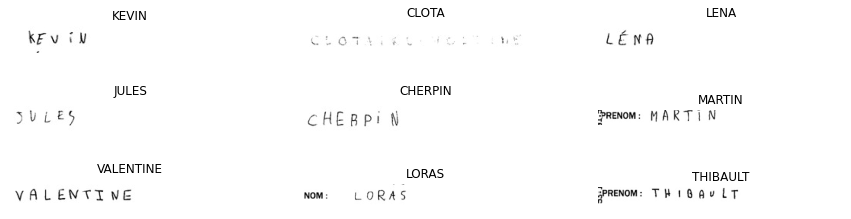

In [21]:
test = pd.read_csv(r'C:\Users\user\Documents\tensorflow\kaggle_handwriting_recognition\input\written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    img_dir =r'C:\Users\user\Documents\tensorflow\kaggle_handwriting_recognition\input/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [22]:
# Model is saved in 'C:\\Users\\user\\Documents\\tensorflow\\kaggle_handwriting_recognition\\model\\saved_model.pb'
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [23]:
os.getcwd()

'C:\\Users\\user\\Documents\\tensorflow\\kaggle_handwriting_recognition'

# Reference

1. [CTC Batch loss documentation](https://www.kite.com/python/docs/keras.backend.tensorflow_backend.ctc_batch_cost)
2. [Understanding CTC loss for speech recognition in Keras](https://stackoverflow.com/questions/57292896/understanding-ctc-loss-for-speech-recognition-in-keras)